IMPORTING THE MODULES NEEDED FOR THE MODEL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

LOADING THE DATASET

In [2]:
df=pd.read_excel('Electric_Production.xlsx')

In [3]:
df.head()

,DATE,Value
0,1985-01-01,72.5052
1,1985-01-02,70.6720
2,1985-01-03,62.4502
3,1985-01-04,57.4714
4,1985-01-05,55.3151


In [4]:
df.tail()

,DATE,Value
392,2017-01-09,98.6154
393,2017-01-10,93.6137
394,2017-01-11,97.3359
395,2017-01-12,114.7212
396,2018-01-01,129.4048


In [5]:
df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)#set date as index

In [6]:
df.shape

(397, 1)

TO FIND NULL VALUES

In [7]:
df.isnull().sum()

Consumption    0
dtype: int64

In [8]:
df.dtypes

Consumption    float64
dtype: object

DATA DESCRIPTION

In [9]:
df.describe()

,Consumption
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


PERFORMING SEASONAL DECOMPOSITION TO REMOVE THE SEASONAL COMPONENT

In [11]:
# Perform seasonal decomposition on the data
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=12)

# Get the seasonal component of the data
seasonal = decomposition.seasonal

# Remove the seasonal component from the data
data_without_seasonality = df - seasonal

# Print the data without the seasonal component
print(data_without_seasonality)

            1985-01-01 00:00:00  1985-01-02 00:00:00  1985-01-03 00:00:00  \
Date                                                                        
1985-01-01                  NaN                  NaN                  NaN   
1985-01-02                  NaN                  NaN                  NaN   
1985-01-03                  NaN                  NaN                  NaN   
1985-01-04                  NaN                  NaN                  NaN   
1985-01-05                  NaN                  NaN                  NaN   
...                         ...                  ...                  ...   
2017-01-09                  NaN                  NaN                  NaN   
2017-01-10                  NaN                  NaN                  NaN   
2017-01-11                  NaN                  NaN                  NaN   
2017-01-12                  NaN                  NaN                  NaN   
2018-01-01                  NaN                  NaN                  NaN   

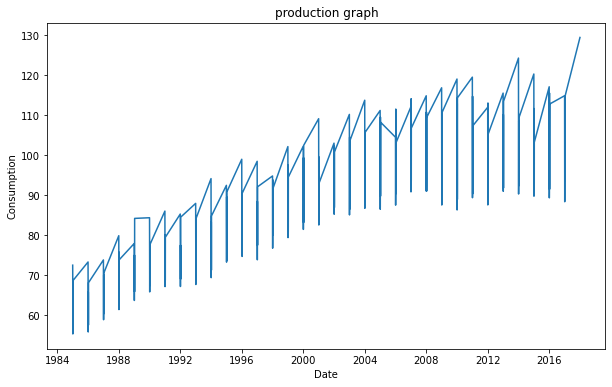

In [12]:
fig = plt.figure(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

A series needs to be stationary for time series forecasting which means the series should have a constant mean, variance and covariance.

As we can clearly see an upward trend in the above graph, it is understood that the mean is not constant.

Since, we have identified that the series is not stationary, we have to stationarise in order to do time series forecasting.
So we will try to convert this into a stationary series.


Let's plot a scatter plot:


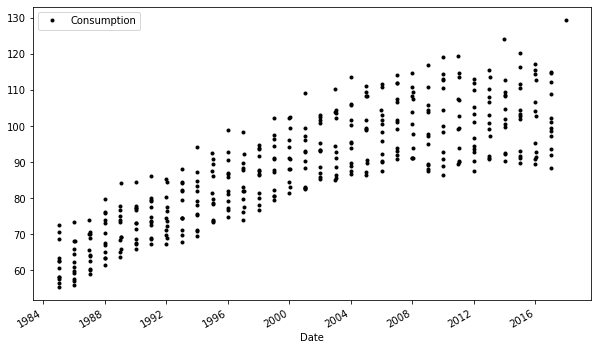

In [13]:
fig = plt.figure(figsize=(10, 6))
df.plot(style='k.',ax=fig.gca())
plt.show()

PERFORMING THE AUGMENTED DICKEY FULLER TEST

ADF (Augmented Dickey-Fuller) Test
The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

The following function is one that can plot a series with its rolling mean and standard deviation.

In [14]:
data = df['Consumption']

In [15]:
result = adfuller(data)

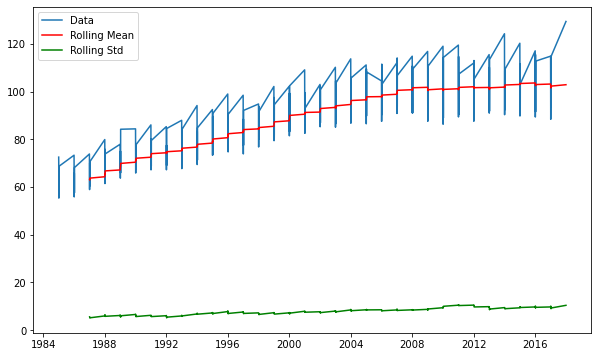

ADF Statistic: -2.256990
p-value: 0.186215


In [16]:
window_size = 30 # the size of the rolling window
rolling_mean = data.rolling(window=window_size).mean()
rolling_std = data.rolling(window=window_size).std()

fig = plt.figure(figsize=(10, 6))
plt.plot(data)
plt.plot(rolling_mean, color='red')
plt.plot(rolling_std, color='green')
plt.legend(['Data','Rolling Mean', 'Rolling Std'])
plt.show()

# Print the test statistic and p-value
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

It is observed through the above graph that the rolling mean is increasing so we can conclude that are series is not stationary.

We can also see that the p-value is also greater than 0.05 which means that the null hypothesis cannot be rejected.
Therefore the series is non-stationary.



In [17]:
# Interpret the results
if result[1] > 0.05:
    print('The data is non-stationary.')
else:
    print('The data is stationary.')

The data is non-stationary.


To get a stationary series, we need to eliminate the trend and seasonality from the series.

In [18]:
data_diff = data.diff().dropna()
data_diff.describe()

count    396.000000
mean       0.143686
std        7.764483
min      -15.756000
25%       -6.208400
50%       -0.045050
75%        6.292800
max       21.551600
Name: Consumption, dtype: float64

In [19]:
result=adfuller(data_diff)

CALCULATING THE ROLLING MEAN AND STANDARD DEVIATION

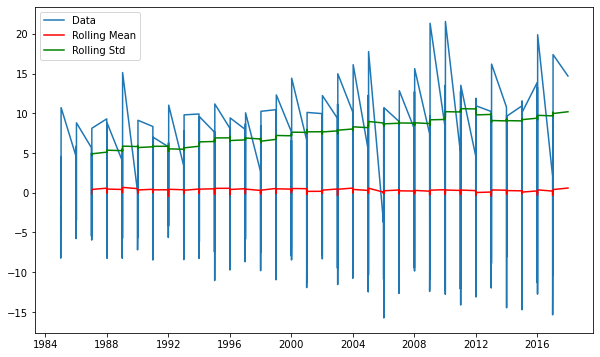

ADF Statistic: -7.104891
p-value: 0.000000


In [20]:
window_size = 30 # the size of the rolling window
rolling_mean = data_diff.rolling(window=window_size).mean()
rolling_std = data_diff.rolling(window=window_size).std()

# Plot the data and the rolling mean/std
fig = plt.figure(figsize=(10, 6))
plt.plot(data_diff)
plt.plot(rolling_mean, color='red')
plt.plot(rolling_std, color='green')
plt.legend(['Data', 'Rolling Mean', 'Rolling Std'])
plt.show()

# Print the test statistic and p-value
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

From the above graph, we can observe that the data has been stationarized.
Now the p-value is less than 0.05

In [21]:
# Interpret the results
if result[1] > 0.05:
    print('The data is non-stationary.')
else:
    print('The data is stationary.')

The data is stationary.


In [22]:
# Get the number of rows in the DataFrame
num_rows = data_diff.shape[0]

# Print the number of rows
print("Number of rows:", num_rows)

Number of rows: 396


SPLITTING THE DATASET INTO TRAINING AND TESTING 

In [23]:
train_data = data_diff[:317]
test_data = data_diff[317:]

In [24]:
print("Train:",train_data.tail())

Train: Date
2011-01-02   -12.1127
2011-01-03    -8.2725
2011-01-04    -9.7445
2011-01-05     0.7115
2011-01-06    12.7506
Name: Consumption, dtype: float64


In [25]:
print("Test",test_data.head())

Test Date
2011-01-07    11.8864
2011-01-08    -1.1110
2011-01-09   -14.1246
2011-01-10    -9.1146
2011-01-11     3.4529
Name: Consumption, dtype: float64


In [26]:
len(data_diff)

396

In [27]:
len(train_data)

317

In [28]:
len(test_data)

79

INTRODUCING THE ARIMA MODEL:

Inorder to find the p and q values, we need to look where the graph cuts off the origin or drops to zero for the first time.
From the above graph, it is observed that the graph cuts off the origin when p value was close to 3.
After finding the p,d and q values, the values are substituted in the ARIMA model.


In [29]:
p = 3
d = 0
q = 5
order = (p, d, q)

# Fit an ARIMA model to the training data
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Print a summary of the model fit
print(model_fit.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  317
Model:                 ARIMA(3, 0, 5)   Log Likelihood                -803.955
Date:                Tue, 16 May 2023   AIC                           1627.911
Time:                        08:57:53   BIC                           1665.500
Sample:                             0   HQIC                          1642.926
                                - 317                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1283      0.013      9.655      0.000       0.102       0.154
ar.L1          0.0661      0.081      0.815      0.415      -0.093       0.225
ar.L2         -0.0669      0.081     -0.831      0.4

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
#using the model to make predictions on testing data
predictions = model_fit.forecast(steps=len(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [31]:
# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(mean_squared_error(test_data, predictions))

# Print the RMSE
print('RMSE: %.2f' % rmse)

RMSE: 3.99


In [32]:
future_forecast = model_fit.forecast(steps=12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
future_forecast

317    10.995220
318    -2.429144
319   -11.731897
320    -7.291460
321     4.590520
322    11.979429
323     7.531484
324    -4.337003
325   -11.713571
326    -7.258712
327     4.596824
328    11.960565
Name: predicted_mean, dtype: float64

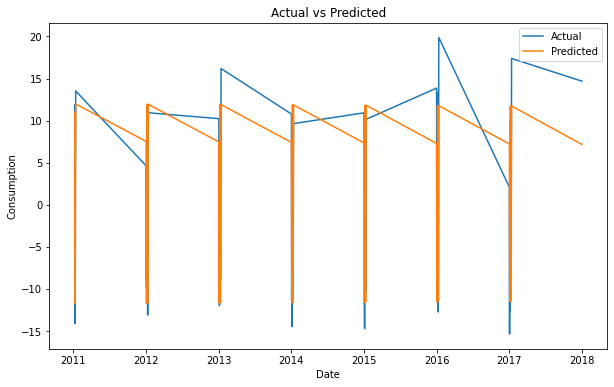

In [34]:
fig = plt.figure(figsize=(10, 6))
# Plot the actual test data and the predicted data
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')

# Set the plot title and labels
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Consumption')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


MAKING FUTURE PREDICTION

In [46]:
# Fit an ARIMA model to the data
model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()

# Generate predictions for a specified number of future steps
start_date = data.index[-1] + pd.DateOffset(days=1)
end_date = data.index[-1] + pd.DateOffset(days=500)
future_index = pd.date_range(start=start_date, end=end_date)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


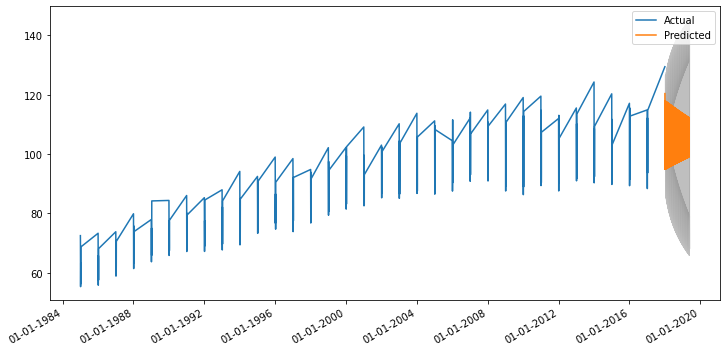

In [48]:
future_predictions = model_fit.get_forecast(steps=len(future_index))

# Plot the predictions and confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data, label='Actual')
ax.plot(future_index, future_predictions.predicted_mean, label='Predicted')
ax.fill_between(future_index,
                future_predictions.conf_int().iloc[:, 0],
                future_predictions.conf_int().iloc[:, 1],
                color='gray', alpha=0.5)
ax.legend()

# Format the x-axis ticks to display date in "dd-mm-yyyy" format
date_format = plt.matplotlib.dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()  # Rotate and align the x-axis labels for better readability

plt.show()